# Synthetic Regression Data



In [3]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \boldsymbol{\epsilon}$$

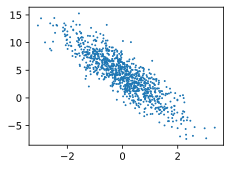

In [6]:
def synthetic_data(w, b, num_examples):
    '''生成y = Xw + b + 噪声'''
    X = torch.normal(0,1,(num_examples, len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0, 0.01, y.shape)

    return X, y.reshape((-1,1))
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

In [4]:
class SyntheticRegressionData(d2l.DataModule):  
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

Each row in `features` consists of a vector in $\mathbb{R}^2$ and each row in `labels` is a scalar

In [4]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([0.9026, 1.0264]) 
label: tensor([2.5148])


Implement the `get_dataloader` method,
takes a batch size, a matrix of features,
and a vector of labels, and generates minibatches of size `batch_size`

In [6]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


Call the existing API in a framework to load data

In [9]:
@d2l.add_to_class(d2l.DataModule)  
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)  
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [10]:
len(data.train_dataloader())

32